# Testing watershed halo finder

Here, we compare the results of our watershed-based halo finder, which works directly on a gridded density field, with the FoF halo finder used by nbodykit, which acts on a particle catalog.

In [2]:
import hickle as hkl
import postEoR.tools as tools
import numpy as np
import matplotlib.pyplot as plt
from hmf import MassFunction

We load in the particle distribution from nbodykit, which has been painted to a gridded density field for use in the watershed halo finder.
1000 particles per cell are used, each with a mass of $97452.59 M_{\odot}$ (to give the field an average density equal to the critical density of the universe).

In [ ]:
dens = hkl.load("nbody_dens_1000_particles_per_cell.hkl")

In [ ]:
halos = tools.find_halos_watershed(dens, box_len=50, HII_dim=250, overdens_cap=9, connectivity=3, compactness=0)
hkl.dump(halos, "alt_watershed_halos_overdens9_conn3.hkl", mode="w")

In [9]:
hlittle = 67.66 / 100
bl_halos = 97452590.3969895 * 250**3 / hlittle**2
ws_halos = hkl.load("alt_watershed_halos_overdens5_conn3.hkl")
nb_halo_mass = hkl.load("halo_masses_nmin5.hkl")
nb_halo_pos = hkl.load("halo_positions_nmin5.hkl")

nb_halo_pos[nb_halo_pos==250] = 249
print(np.max(nb_halo_pos))

nb_halo_field = np.zeros([250, 250, 250])
print(np.shape(nb_halo_pos))

for i in range(np.shape(nb_halo_pos)[0]):
    coord = nb_halo_pos[i]
    nb_halo_field[coord[0], coord[1], coord[2]] += nb_halo_mass[i]

# normalising to the expected total mass of the comoving box
ws_halos *= np.sum(bl_halos) / np.sum(ws_halos)
nb_halo_field *= np.sum(bl_halos) / np.sum(nb_halo_field) 

"""nb_halo_field[nb_halo_field < 1e11] = 0
ws_halos[ws_halos < 1e11] = 0"""

"""nb_halo_field[nb_halo_field > 1e13] = 0
ws_halos[ws_halos > 1e13] = 0"""


print(np.count_nonzero(nb_halo_field))
print(np.count_nonzero(nb_halo_mass)) # check how many nb halos have been combined into one due to gridding
print(np.count_nonzero(ws_halos))



249
(54273, 3)
29243
54273
27551


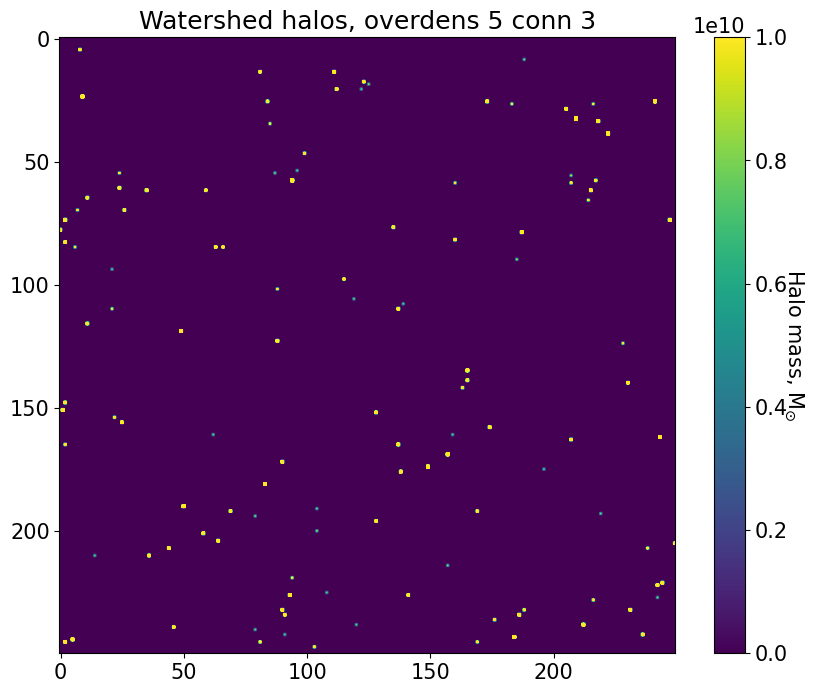

In [22]:
plt.rcParams['figure.figsize'] = [10, 8]


plt.imshow(ws_halos[:, :, 10], vmax=1e10)
plt.title("Watershed halos, overdens 5 conn 3")
cbar = plt.colorbar()
cbar.set_label("Halo mass, M$_{\odot}$", rotation=270, labelpad = 12)

Now, we plot the nbodykit halos, which have been painted to a mesh for analysis here.
We remove any negative halo values that have arisen from any interlacing and set them to 0, and also convert the field from a halo overdensity to solar masses.

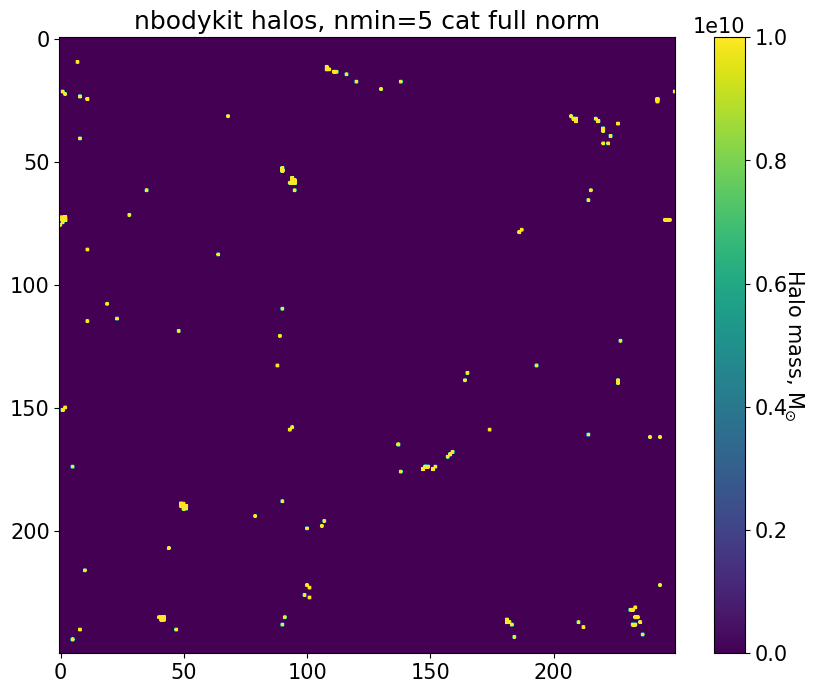

In [23]:

plt.rcParams['figure.figsize'] = [10, 8]
plt.imshow(nb_halo_field[:, :, 10], vmax=1e10)
plt.title("nbodykit halos, nmin=5 cat full norm")
cbar = plt.colorbar()
cbar.set_label("Halo mass, M$_{\odot}$", rotation=270, labelpad = 12)


We plot the theoretical HMF, the HMF of the watershed halos, and the HMF of the nbodykit halos on the same plot for a direct comparison.

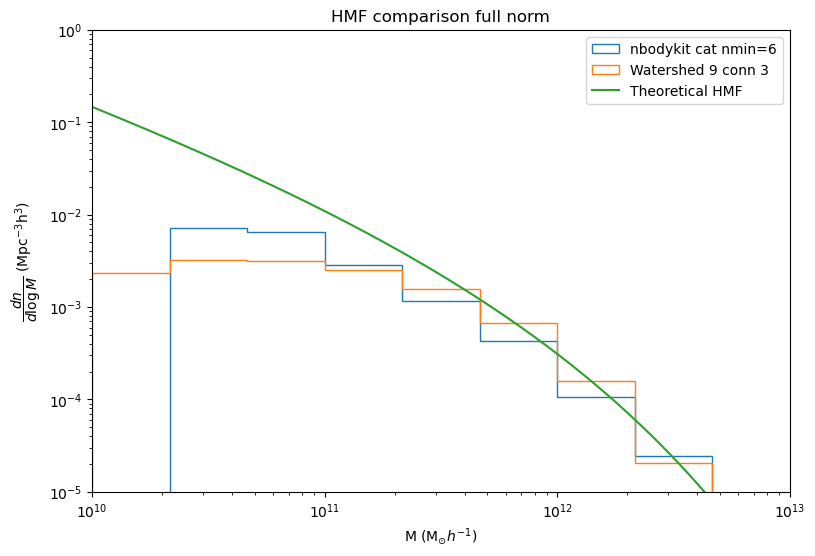

In [10]:
# mega plot


"""Mmin = 10.7
Mmax = 12.5"""

Mmin=10
Mmax=13
box_len=50
OMm = 0.30964144154550644
z = 4
hlittle = 67.66 / 100


bins1 = np.geomspace(10**Mmin, 10**Mmax, 10)
counts, bins = np.histogram(nb_halo_field, bins1)
los_dist = box_len
plt.rcParams['figure.figsize'] = [9, 6]
bins_plot = (bins[1:] + bins[:-1]) / 2
plt.hist(bins_plot, bins, weights=(2 * counts / (np.log(bins[1:]+bins[:-1])*box_len**2*los_dist)), histtype='step', label="nbodykit cat nmin=6", color="tab:blue")

bins1 = np.geomspace(10**Mmin, 10**Mmax, 10)
counts, bins = np.histogram(ws_halos, bins1)
los_dist = box_len
plt.rcParams['figure.figsize'] = [9, 6]
bins_plot = (bins[1:] + bins[:-1]) / 2
plt.hist(bins_plot, bins, weights=(2 * counts / (np.log(bins[1:]+bins[:-1])*box_len**2*los_dist)), histtype='step', label="Watershed 9 conn 3", color="tab:orange")


mf1 = MassFunction(Mmin=Mmin-1, Mmax=Mmax+1, z = z,
            cosmo_params={"Om0":OMm}, 
            hmf_model="Watson") 

plt.plot(mf1.m, mf1.dndm * mf1.m, label="Theoretical HMF", color="tab:green")
plt.title("HMF comparison full norm")
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.ylabel('$\dfrac{dn}{d\log M}$ (Mpc$^{-3} $h$^3$)')
plt.xlabel('M (M$_{\odot} h^{-1}$)')
plt.xlim(10**Mmin, 10**Mmax)
plt.ylim(1e-5, 1e-0)

plt.show()

Generated bins.
Generated bins.


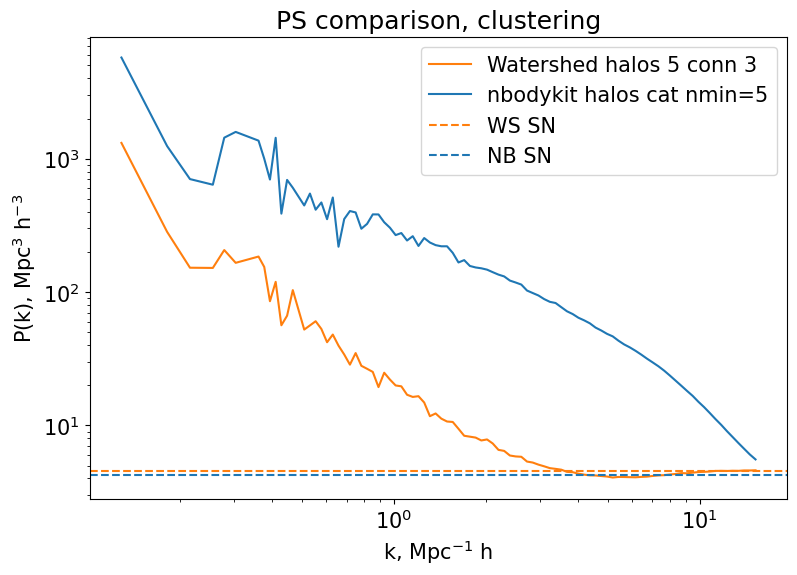

In [19]:
from postEoR.analysis import get_PS

HII_dim = 250
box_len = 50
n = np.size(ws_halos)

ws_sn = box_len**3 / np.count_nonzero(ws_halos) 

nb_sn = box_len**3 / np.count_nonzero(nb_halo_field) # this is fine

ws_halos[ws_halos>0] = 1
ws_halos[ws_halos<0] = 0
"""nb_halo_field[nb_halo_field>0]=1
nb_halo_field[nb_halo_field<0]=0"""

nb_halo_field /=np.mean(nb_halo_field)
ws_halos /= np.mean(ws_halos)

ws_k, ws_ps, _ = get_PS(ws_halos, 50, 250) 

n1_k, n1_ps, _ = get_PS(nb_halo_field, 50, 250) 


plt.rcParams['figure.figsize'] = [9, 6]
plt.plot(ws_k, ws_ps, color="tab:orange", label="Watershed halos 5 conn 3")
plt.plot(n1_k, n1_ps, color="tab:blue", label="nbodykit halos cat nmin=5")
plt.axhline(y = ws_sn, color = 'tab:orange', linestyle = '--', label="WS SN") 
plt.axhline(y = nb_sn, color = 'tab:blue', linestyle = '--', label="NB SN") 


plt.yscale("log")
plt.xscale("log")
plt.ylabel("P(k), Mpc$^3$ h$^{-3}$")
plt.xlabel("k, Mpc$^{-1}$ h")
plt.legend()
plt.title("PS comparison, clustering")
plt.show()